# Forecasting Bike Rental Demand

Bike sharing systems are the new generation of traditional bike rentals where the whole process from membership, rental and return has become automatic. Through these systems, the user can easily rent a bike from a particular position and return back to another area.

We are going to create a neural network and use it to predict daily bike rentals.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights.

In [2]:
data_path = 'data/hour.csv'
# Read csv data file using Pandas
rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


This dataset has the number of riders for each hour of each day from the 1st of January 2011 to the 31st of December 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. We have information about temperature, humidity, and wind speed, all of this likely affecting the number of riders. The first few rows of the data are shown above.

Below is a plot showing the number of bike riders over the first ten days in the data set. You can see the hourly rentals here. We can see that the weekends have lower over all rentals and there are spikes when people are biking to and from work during the week.

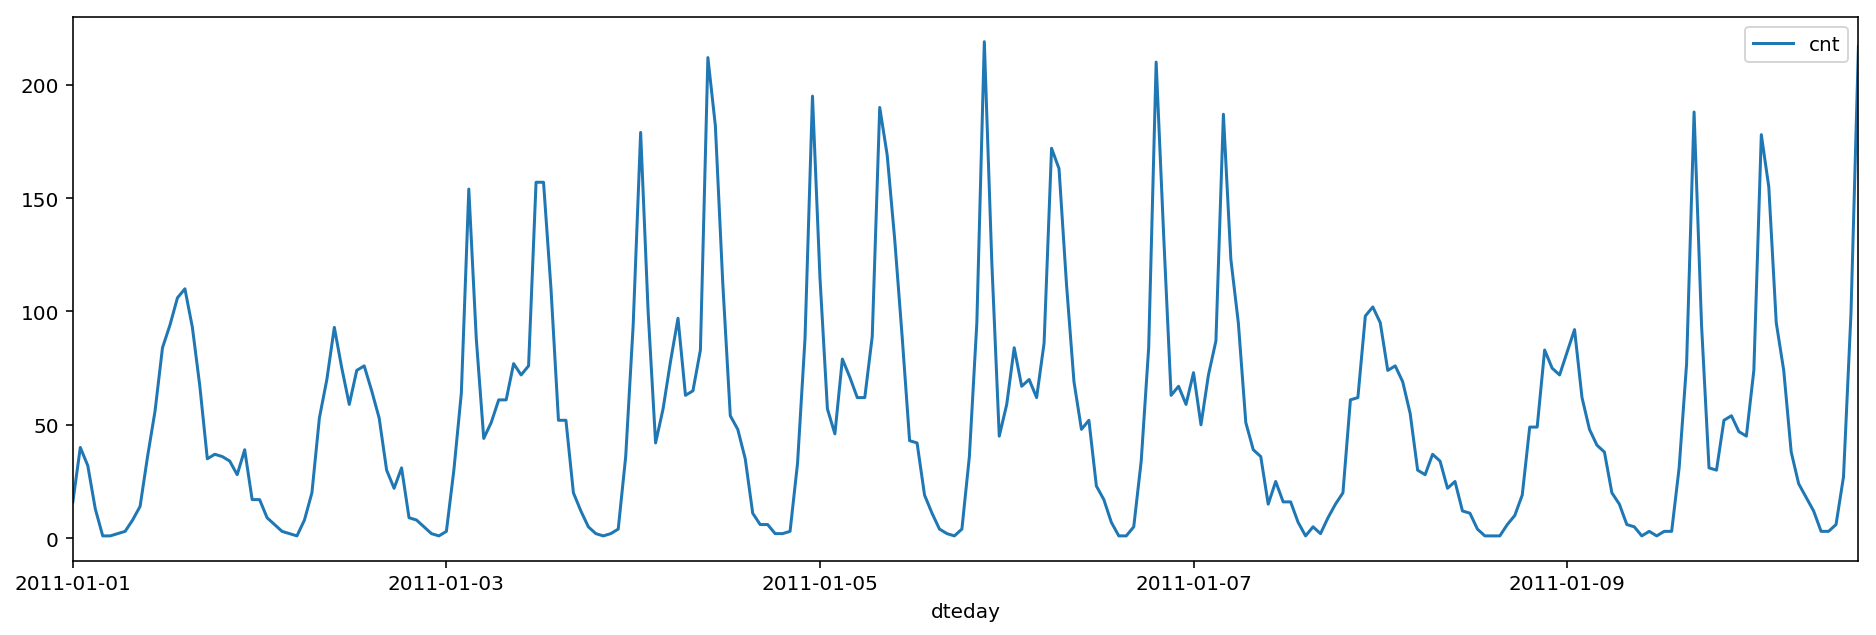

In [4]:
rides[:24*10].plot(x='dteday', y='cnt', figsize=[16,5])

## Data preparation
### Coverting Categorical Cariables 
There are some categorical variables like season, weather, month. To include these in the model, we'll need to make binary indicator variables. This process is simple to do with Pandas by directly using the `get_dummies()` function.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Normalising Target Variables
To make training the network easier,  normalising each of the continuous variables. That will shift and scale the variables such that they have zero mean and a standard deviation of one.

The scaling factors are saved, so we convert back when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data set

We will save the last 21 days of the data to use as a test set after we've trained the network. We will use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We will split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (validation set).

In [8]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Build the network

The network has three layers, an input layer, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer will only have one node, and which will be utilised for the regression, the output of the node is the same as the input of the node. Hence the activation function is $f(x)=x$. 

A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. 

We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called forward propagation.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called backpropagation.  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        
        self.learning_rate = learning_rate
    
        # Activation function - Sigmoid function
        self.activation_function = sigmoid_function
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # Forward pass #
        
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
    
        # Backward pass #
        
        # Output errors
        output_errors = targets - final_outputs

        # Backpropagated error
        hidden_errors = output_errors * self.weights_hidden_to_output * 1.0
        hidden_grad = np.dot(hidden_errors.T * hidden_outputs * (1 - hidden_outputs), inputs.T)
        
        # Update the weights
        grad_out = np.dot(hidden_outputs, output_errors * 1.0)
        self.weights_hidden_to_output += self.learning_rate * grad_out.T / inputs.shape[1] 
        self.weights_input_to_hidden += self.learning_rate * hidden_grad / inputs.shape[1]
        
    def run(self, inputs_list):
        # Forward pass #
        
        # Input layer
        inputs = np.array(inputs_list, ndmin=2).T
        
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs =  np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs 
        
        return final_outputs

In [10]:
def mean_square_error(y, Y):
    return np.mean((y-Y)**2)

def sigmoid_function(x):
    return 1 / (1 + np.exp(-x))

## Training the network

The strategy here is to find hyperparameters such that the error on the training set is low, such that the network is not overfitting to the data. Overfitting can happen when you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalise to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. Ensure that it is enough epochs to train the network well but not too many that could cause overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes, the more accurate predictions the model will make. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units.

In [11]:
import sys

# Hyperparameters #
epochs = 5000
learning_rate = 0.01
hidden_nodes = 10
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.iloc[batch].values, 
                              train_targets.iloc[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = mean_square_error(network.run(train_features), train_targets['cnt'].values)
    val_loss = mean_square_error(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.059 ... Validation loss: 0.168

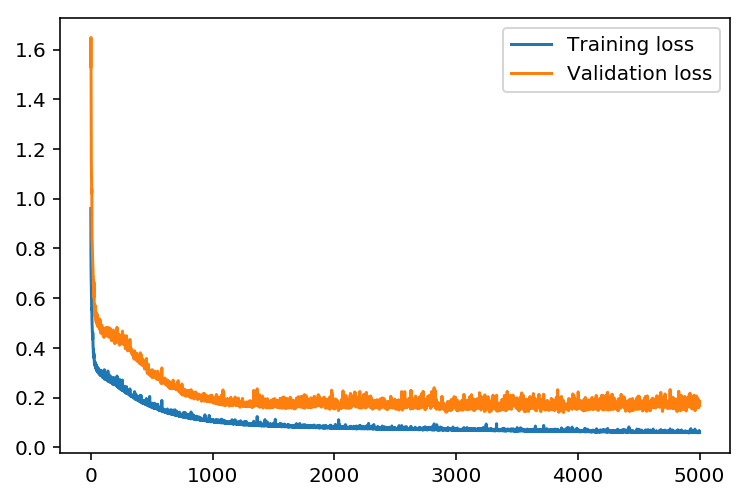

In [12]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

## Check out predictions

Here, use the test data to view how well the network is modeling the data.

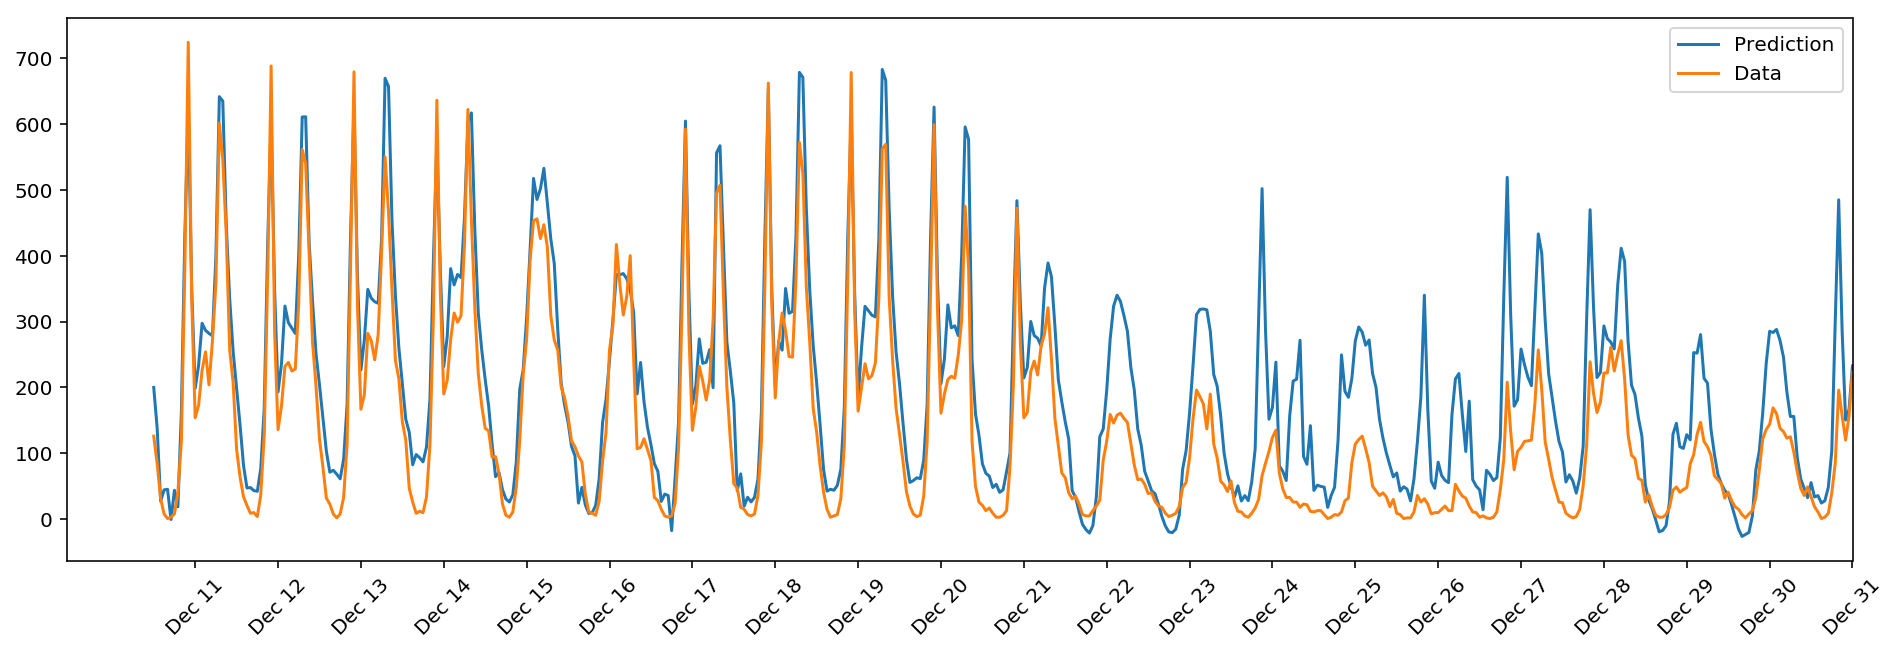

In [13]:
fig, ax = plt.subplots(figsize=(16,5))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)